# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: 03
* Students: Jonathan Dönz (for the indivudual submission) or Dönz Jonathan, Esguerra Martin, Geffroy Charles, Vojinovic Stefano (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [3]:
# column_list = ["paper_id"] + list(range(1433)) + ["class_label"]
# pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
# pd_content.head()
# actually better:
column_list = list(range(1433)) + ["class_label"]
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
pd_content.index.name = "paper_id"
pd_content.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,class_label
paper_id,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [4]:
pd_content.class_label.value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [5]:
my_field = "Probabilistic_Methods"
# features = pd_content[pd_content.class_label == my_field].drop(columns=["paper_id", "class_label"]).values
features = pd_content[pd_content.class_label == my_field].drop(columns=["class_label"]).values
features.shape

(426, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [6]:
n_papers = features.shape[0]
distance = np.zeros([n_papers, n_papers])
distance.shape

(426, 426)

In [7]:
n_papers = features.shape[0]
distance = np.zeros([n_papers, n_papers])
for i in range(n_papers):
    for j in range(n_papers):
        distance[i, j] = np.linalg.norm( features[i, :] - features[j, :] )
distance.shape

(426, 426)

Check the mean pairwise distance $\mathbb{E}[D]$.

Plot an histogram of the euclidean distances.

In [8]:
mean_distance = distance.mean()
mean_distance

5.790575729028696

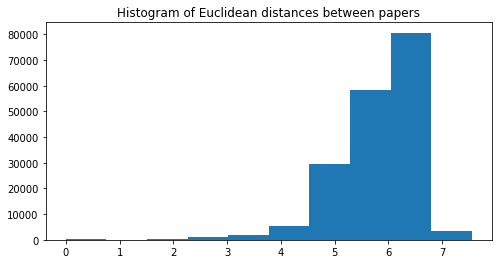

In [9]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [10]:
A_feature = np.zeros(distance.shape)
A_feature.shape

(426, 426)

In [11]:
threshold = mean_distance
A_feature = np.zeros(distance.shape)
A_feature[distance < threshold] = 1
np.fill_diagonal(A_feature, 0)

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [12]:
df = pd.read_csv('data/cora/cora.cites', delimiter='\t', names=["cited_paper", "citing_paper"])
df.head()

,cited_paper,citing_paper
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [13]:
df.describe()

,cited_paper,citing_paper
count,5429.000000,5.429000e+03
mean,115009.455148,5.604759e+05
std,188229.783205,4.710471e+05
min,35.000000,3.500000e+01
25%,6334.000000,7.855200e+04
50%,31353.000000,5.233940e+05
75%,119686.000000,1.113995e+06
max,954315.000000,1.155073e+06


In [14]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

sorted_papers = np.sort(np.unique(cora_cites))
n_papers = len(sorted_papers)
A_citation = np.zeros((n_papers, n_papers))
for cited_paper, citing_paper in cora_cites:
    i, j = np.where(cited_paper == sorted_papers), np.where(citing_paper == sorted_papers)
    A_citation[i, j] = 1
    A_citation[j, i] = 1
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [15]:
# Your code here.
interest_paper_ids = pd_content[pd_content.class_label == my_field].index.values
interest_paper_indices = []
for i in interest_paper_ids:
    interest_paper_indices.append(int(np.where(i == sorted_papers)[0]))
A_citation = np.take(A_citation, interest_paper_indices, axis=0)
A_citation = np.take(A_citation, interest_paper_indices, axis=1)

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [16]:
# Your code here.
np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [17]:
A_citation.shape

(426, 426)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [18]:
num_edges_feature = A_feature.sum() / 2
num_edges_citation = A_citation.sum() / 2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695.0
Number of edges in the citation graph: 660.0


Plot the degree distribution histogram for each of the graphs.

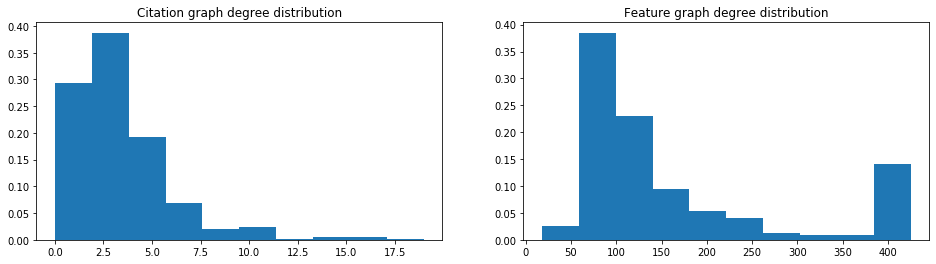

In [19]:
degrees_citation = A_citation.sum(axis=1) # Your code here.
degrees_feature = A_feature.sum(axis=1) # Your code here.

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [20]:
# could use:
# num_nodes_citation = A_citation.shape[0]
# cit_moment_1 = 2 * num_edges_citation / num_nodes_citation
# or:
cit_moment_1 = np.mean(degrees_citation) # Your code here.
cit_moment_2 = np.var(degrees_citation) + cit_moment_1**2 # Your code here.

feat_moment_1 = np.mean(degrees_feature)# Your code here.
feat_moment_2 = np.var(degrees_feature) + feat_moment_1**2 # Your code here.

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 3.0985915492957745
2nd moment of citation graph: 16.6056338028169
1st moment of feature graph: 162.88732394366198
2nd moment of feature graph: 40686.178403755875


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**

The first moment informs on how many _direct_ neighbors a node has on average.


The second moment informs on how many neighbors a node has on average _two-hops away_ (at a distance of 2 edges from the node).

The two distributions take place over very different ranges of values. The citation graph's degrees are between 0 and 19, whereas the feature graph's degrees take values between 18 and 425. This explains the difference in magnitude of their moments.

The feature's graph has a second hump at high degree (`k` = 400).
This pulls the average degree to higher values compared to what would be expected from observing the distribution without this second hump.
Its effect on the value of the second moment is even larger as it is the expectation value of the _square_ of `k`.

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

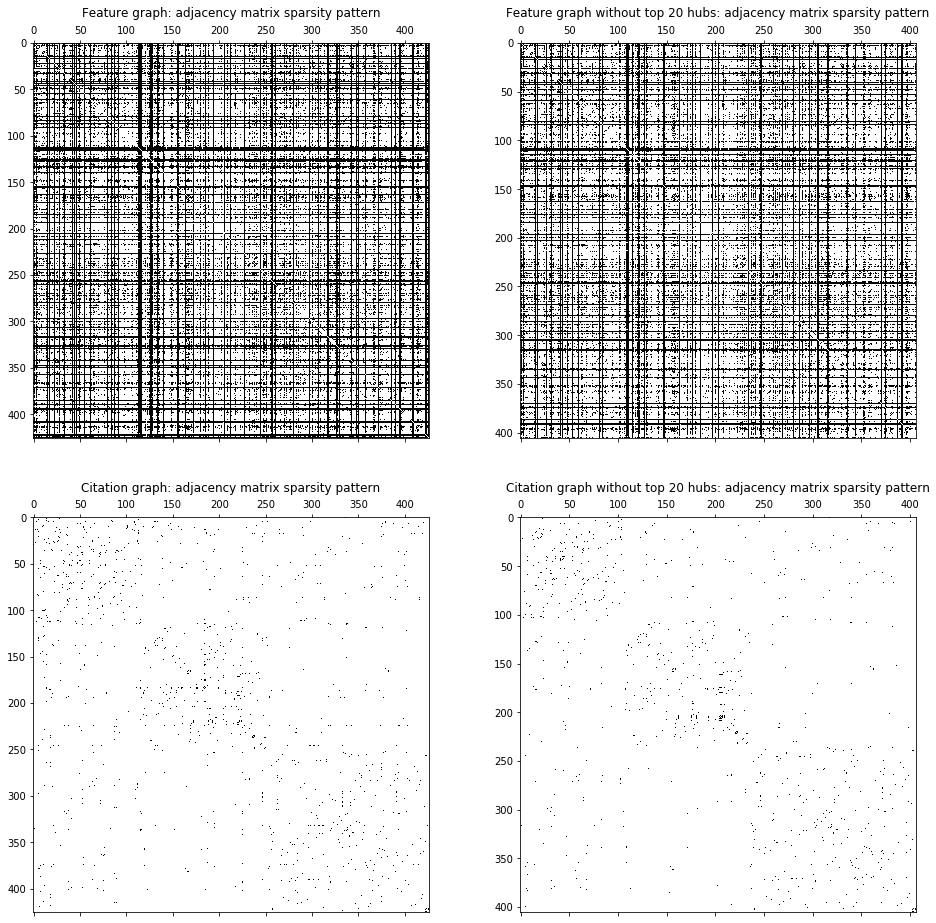

In [21]:
# get indices of largest hubs
n_hubs = 20
largest_hubs_feature_inds = np.argsort(degrees_feature)[::-1][:n_hubs]
largest_hubs_citation_inds = np.argsort(degrees_citation)[::-1][:n_hubs]

# remove them from adjacency matrices
# remove rows
reduced_A_feature = np.delete(A_feature, largest_hubs_feature_inds, axis=0)
reduced_A_citation = np.delete(A_citation, largest_hubs_citation_inds, axis=0)
# remove columns
reduced_A_feature = np.delete(reduced_A_feature, largest_hubs_feature_inds, axis=1) # Your code here
reduced_A_citation = np.delete(reduced_A_citation, largest_hubs_citation_inds, axis=1) # Your code here

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

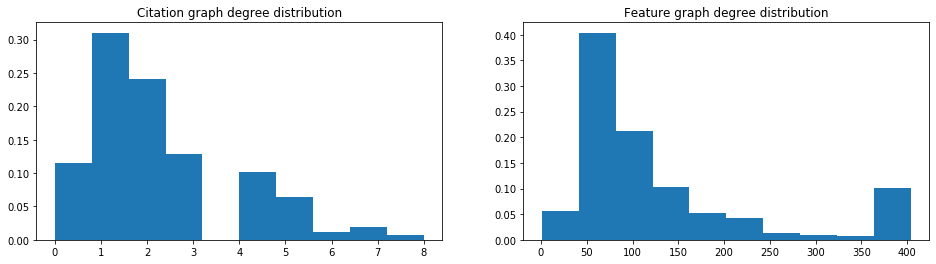

In [22]:
reduced_degrees_feat = reduced_A_feature.sum(axis=1) # Your code here.
reduced_degrees_cit = reduced_A_citation.sum(axis=1) # Your code here.

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [23]:
reduced_cit_moment_1 = np.mean(reduced_degrees_cit) # your code here.
reduced_cit_moment_2 = np.var(reduced_degrees_cit) + reduced_cit_moment_1**2 # your code here.

reduced_feat_moment_1 = np.mean(reduced_degrees_feat) # your code here.
reduced_feat_moment_2 = np.var(reduced_degrees_feat) + reduced_feat_moment_1**2 # your code here.

print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 2.1724137931034484
Citation graph second moment: 7.527093596059114
Feature graph first moment:  129.99014778325125
Feature graph second moment:  28199.596059113304


Print the number of edges in the reduced graphs.

In [24]:
num_edges_feature = A_feature.sum() / 2
num_edges_citation = A_citation.sum() / 2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695.0
Number of edges in the citation graph: 660.0


In [25]:
# Your code here
num_edges_reduced_feat = reduced_A_feature.sum() / 2
num_edges_reduced_cit = reduced_A_citation.sum() / 2
print(f"Number of edges in the reduced feature graph: {num_edges_reduced_feat}")
print(f"Number of edges in the reduced citation graph: {num_edges_reduced_cit}")

Number of edges in the reduced feature graph: 26388.0
Number of edges in the reduced citation graph: 441.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here:**

The first moments decrease by 29.9% and 20.2% for the citation and feature graphs respectively. Considering that the 20 nodes removed made up 4.7% of the total number of nodes, these 20 nodes had a rather large impact in increasing the average degree in both graphs.

The second moments decrease by 54.7% and 30.7% for the citation and feature graphs respectively. The largest decrease is for the citation graph, where all the nodes with highest degrees (`k` between 9 and 19) have been removed.

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [26]:
threshold = 3.1
A_feature_pruned = np.zeros(distance.shape)
A_feature_pruned[distance < threshold] = 1
np.fill_diagonal(A_feature_pruned, 0)
num_edges_feature_pruned = A_feature_pruned.sum() / 2
num_edges_feature_pruned

720.0

In [27]:
threshold = 3.1 # Your code here.

A_feature_pruned = np.zeros(distance.shape)
A_feature_pruned[distance < threshold] = 1 # Your code here.
np.fill_diagonal(A_feature_pruned, 0)
num_edges_feature_pruned = A_feature_pruned.sum() / 2

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 34695.0
Number of edges in the feature graph after pruning: 720.0
Number of edges in the citation graph: 660.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

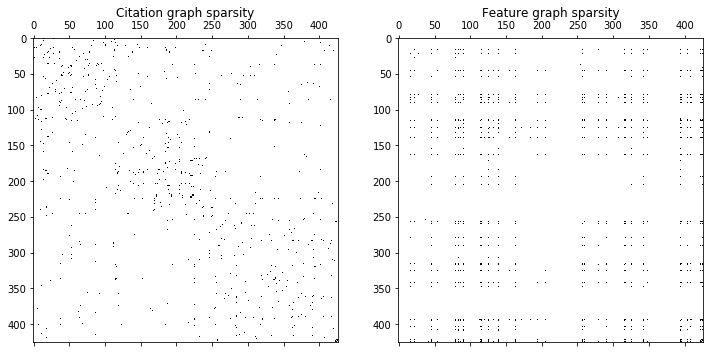

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [29]:
N = 10
path_matrix_citation = np.linalg.matrix_power(A_citation, N) # Your code here.
path_matrix_feature = np.linalg.matrix_power(A_feature, N) # Your code here.

Check the sparsity pattern for both of path matrices.

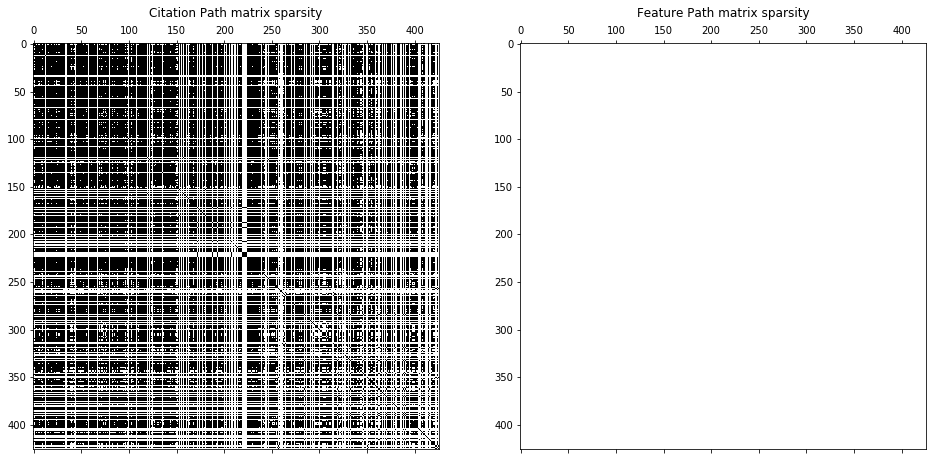

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

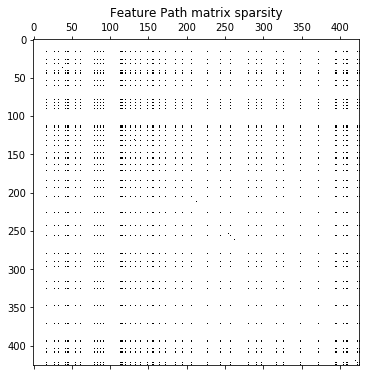

In [31]:
N = 10
path_matrix_pruned = np.linalg.matrix_power(A_feature_pruned, N) # Your code here.

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**

TO ANSWER

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 

One can compute the successive powers of the adjacency matrix $A \in \mathbb{R}^{m \times m}$. If there is an $ n \in \mathbb{N} < m $ such that $ A^n $ has every element different from zero, it means that the graph is connected because one can go from any node $i$ to any other node $j$ in $n$ steps.

If there is still at least one element equal to zero in $A^n$, with $ n=m $, then the graph whose adjacency matrix is $A$ is not connected.

The original feature graph is connected according to this definition because $A^n$ has all elements non zero with $n=2$.

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**

One can count the iterations (using variable $k \in \mathbb{N}$) while computing the successive powers of $A$ and check after each iteration whether the matrix $A^k$ (aka the path matrix) has all its elements different from zero. The _diameter_ is equal to the smallest $k$ such that $A^k$ satisfies this condition.

If any of your graphs is connected, calculate the diameter using that process.

In [32]:
def get_diameter(A):
    m = A.shape[0]
    k = 1
    A_k = A.copy()
    # don't go into loop if all elements of A_k are non-zeros, or if k == m
    while (np.count_nonzero(A_k) < m**2) and (k < m):
        A_k = A_k @ A
        k += 1
    if k == m:
        raise ValueError('The graph is not connected.')
    else:
        return k

diameter = get_diameter(A_feature) # Your code here.
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [33]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [34]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [35]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 426, Number of edges: 660
Number of self-loops: 0, Number of connected components: 48


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [36]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 426, Number of edges: 720
Number of self-loops: 0, Number of connected components: 365


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [37]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

426

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [38]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

690.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**

In [39]:
p = G_citation.number_of_edges() * 2 / (n * (n - 1)) # Your code here.
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [40]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 688 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**

In [41]:
# preferential attachment parameter is the average node degree $<k>$
q = int(2 * G_citation.number_of_edges() / n) # Your code here.
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [42]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 1269 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [43]:
giant_citation = max(nx.connected_component_subgraphs(G_citation), key=len) # Your code here.
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 333 nodes and 582 edges.


In [44]:
giant_feature = max(nx.connected_component_subgraphs(G_feature), key=len) # Your code here.
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 59 nodes and 717 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [45]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len) # Your code here.
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 414 nodes and 687 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**

In [63]:
giant_citation.number_of_nodes() / G_citation.number_of_nodes()

0.7816901408450704

In [64]:
np.log(G_citation.number_of_nodes())

6.054439346269371

In [ ]:
# TODO
S = giant_citation.number_of_nodes() / G_citation.number_of_nodes()
p_new = # Your code here.
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [ ]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len) # Your code here.
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

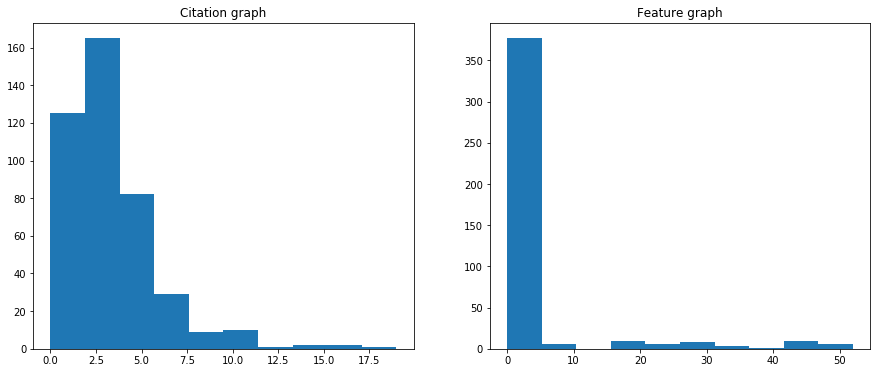

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = [G_citation.degree(n) for n in G_citation.nodes()] # Your code here.
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = [G_feature.degree(n) for n in G_feature.nodes()] # Your code here.
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**

TO ANSWER

Now, plot the degree distribution historgrams for the simulated networks.

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = [G_er.degree(n) for n in G_er.nodes()] # Your code here.
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = [G_ba.degree(n) for n in G_ba.nodes()] # Your code here.
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = [G_er_new.degree(n) for n in G_er_new.nodes()] # Your code here.
axes[2].hist(er_new_degrees);

SyntaxError: invalid syntax (<ipython-input-51-e4dc42062f4a>, line 9)

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [52]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 426 nodes and 720 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 

TO ANSWER

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [53]:
nx.average_clustering(G_citation)

0.2402694603120846

In [54]:
nx.average_clustering(G_feature)

0.10990779169766017

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

In [57]:
(G_citation.number_of_edges() - G_feature.number_of_edges() )/ G_feature.number_of_edges()

-0.08333333333333333

In [58]:
G_citation.number_of_edges(), G_feature.number_of_edges()

(660, 720)

**Your answer here:**
TO IMPROVE

The clustering coefficient tells us the average fraction of links between direct neighbors of a given node.

Interestingly in our case the citation graph has a larger average clustering coefficient than the feature graph despite having having less edges overall. It makes sense intuitively that the citation graph has a somewhat large clustering coefficient as we would expect a scientific paper to cite papers that are related, therefore that might also cite each other.

Now, let us check the average clustering coefficient for the simulated networks.

In [59]:
nx.average_clustering(G_er)

0.0032975631567180867

In [60]:
nx.average_clustering(G_ba)

0.062269299766748276

In [61]:
nx.average_clustering(nx.Graph(G_config))

0.056828129549803236

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

The clustering coefficients obtained from the generated random networks are lower than the clustering coefficients of our two real networks. This is generally the case when comparing random versus real networks.

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

TO ANSWER

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [62]:
# TODO
# Your code here.

Comment on the similarities of your match.

**Your answer here:**

TO ANSWER